In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# 1. Load the processed data
print("Loading data...")
df = pd.read_csv('../data/processed/fraud_data_processed.csv')

# 2. Separate Features (X) and Target (y)
X = df.drop(columns=['class'])
y = df['class']

# 3. Stratified Train-Test Split (80/20)
# Stratify ensures we have the same proportion of fraud in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Apply SMOTE (Only to Training Data!)
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"✅ Data Ready. Training Shape: {X_train_res.shape}")

Loading data...
Applying SMOTE...
✅ Data Ready. Training Shape: (219136, 23)


Training Logistic Regression...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.54      0.69      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.81      0.78     30223
weighted avg       0.93      0.91      0.92     30223



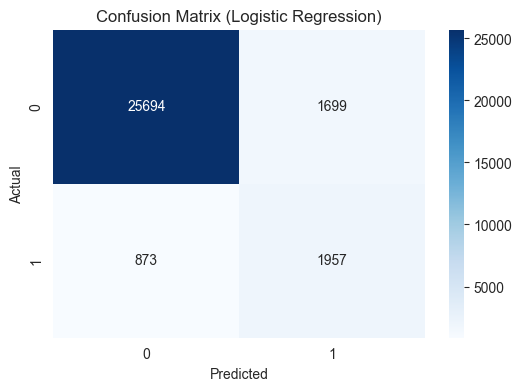

AUC-PR Score: 0.6617


In [2]:
# --- LOGISTIC REGRESSION BASELINE ---
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_res, y_train_res)

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# --- EVALUATION ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate AUC-PR (Area Under Precision-Recall Curve)
# This is the Gold Standard metric for imbalanced fraud data
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR Score: {auc_pr:.4f}")

Training XGBoost Model...


C:\Users\HP\PycharmProjects\fraud-detection\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:41:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27393
           1       0.90      0.56      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.78      0.83     30223
weighted avg       0.95      0.95      0.95     30223



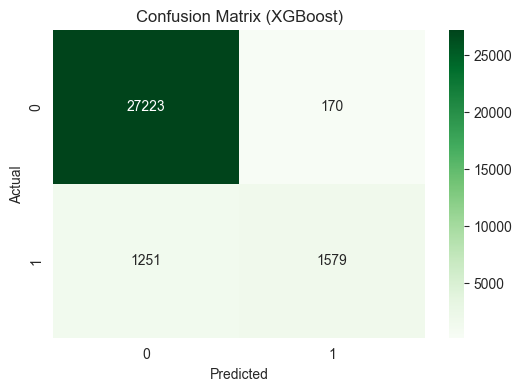

XGBoost AUC-PR Score: 0.7080
Baseline AUC-PR Score: 0.6617


In [3]:
import xgboost as xgb

# --- TRAIN XGBOOST CLASSIFIER ---
print("Training XGBoost Model...")
# We use the same SMOTE-resampled data to be fair
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_res, y_train_res)

# --- PREDICTIONS ---
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# --- EVALUATION ---
print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- COMPARE PERFORMANCE (AUC-PR) ---
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
print(f"XGBoost AUC-PR Score: {auc_pr_xgb:.4f}")
print(f"Baseline AUC-PR Score: {auc_pr:.4f}") # Compare with previous

C:\Users\HP\PycharmProjects\fraud-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1000x600 with 0 Axes>

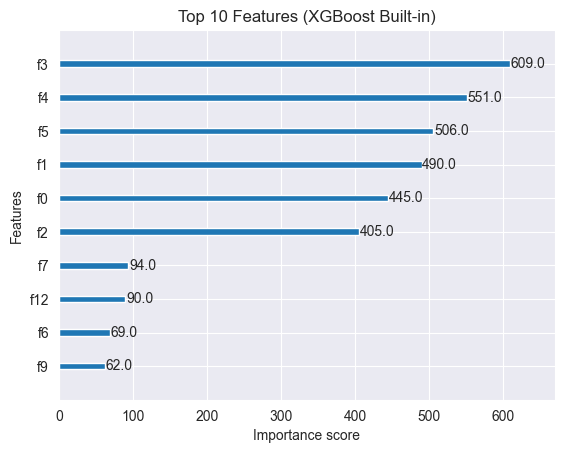

In [4]:
import matplotlib.pyplot as plt  # <--- This fixes the NameError
import xgboost as xgb
import shap

# --- 1. FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Top 10 Features (XGBoost Built-in)')
plt.show()

In [5]:
# --- MODEL COMPARISON & SELECTION ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Helper function to gather metrics
def get_metrics(name, y_true, y_pred, y_proba):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Fraud)': precision_score(y_true, y_pred),
        'Recall (Fraud)': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-PR': auc(precision_recall_curve(y_true, y_proba)[1],
                      precision_recall_curve(y_true, y_proba)[0])
    }

# 2. Compile metrics into a DataFrame
metrics_df = pd.DataFrame([
    get_metrics('Logistic Regression', y_test, y_pred, y_pred_proba),
    get_metrics('XGBoost', y_test, y_pred_xgb, y_pred_proba_xgb)
])

# 3. Display the comparison
print("\n--- FINAL MODEL COMPARISON ---")
print(metrics_df)

# 4. Save the best model (XGBoost)
import joblib
print("\nSaving best model...")
joblib.dump(xgb_model, '../models/xgboost_fraud_model.pkl')
print("✅ Model saved to 'models/xgboost_fraud_model.pkl'")


--- FINAL MODEL COMPARISON ---
                 Model  Accuracy  Precision (Fraud)  Recall (Fraud)  F1-Score  \
0  Logistic Regression  0.914899           0.535284        0.691519  0.603454   
1              XGBoost  0.952983           0.902802        0.557951  0.689670   

     AUC-PR  
0  0.661707  
1  0.707954  

Saving best model...


FileNotFoundError: [Errno 2] No such file or directory: '../models/xgboost_fraud_model.pkl'

In [6]:
import os
import joblib

# Define the path
model_path = '../models/xgboost_fraud_model.pkl'

# Create the directory if it doesn't exist
model_dir = os.path.dirname(model_path)
if not os.path.exists(model_dir):
    print(f"Creating directory: {model_dir}")
    os.makedirs(model_dir)

# Save the model
print("Saving best model...")
joblib.dump(xgb_model, model_path)
print(f"✅ Model successfully saved to '{model_path}'")

Creating directory: ../models
Saving best model...
✅ Model successfully saved to '../models/xgboost_fraud_model.pkl'



--- Starting SHAP Analysis ---
Calculating SHAP values... (This allows us to see WHY the model flags fraud)


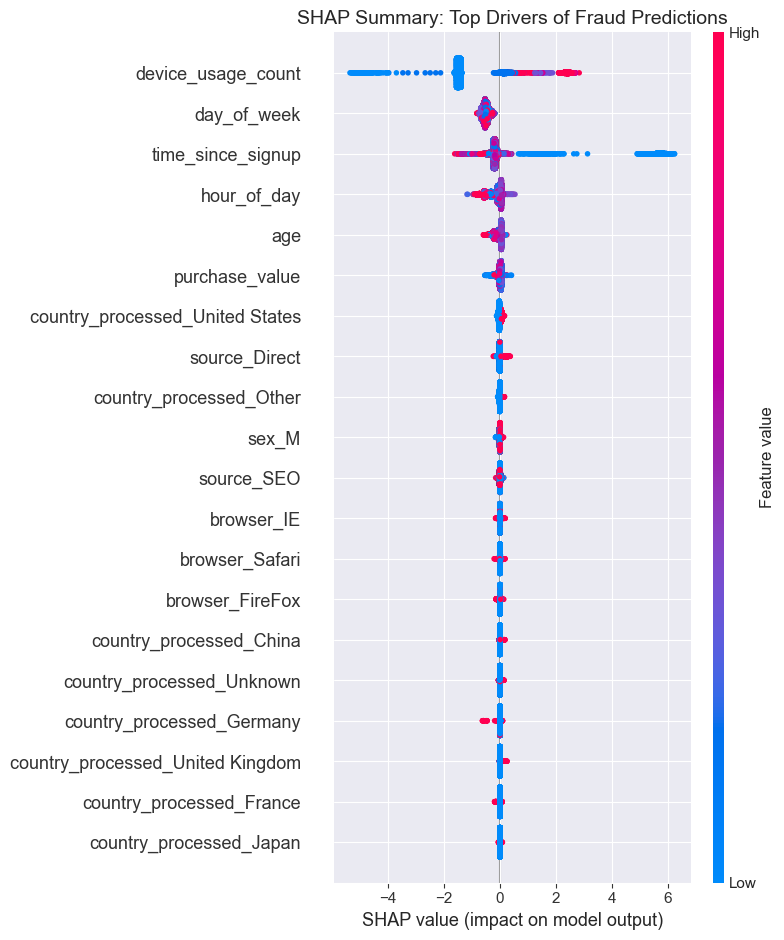

In [7]:
# --- SHAP EXPLAINABILITY ---
print("\n--- Starting SHAP Analysis ---")
print("Calculating SHAP values... (This allows us to see WHY the model flags fraud)")

# 1. Initialize the Explainer
explainer = shap.TreeExplainer(xgb_model)

# 2. Calculate SHAP values for the test set
# This converts the complex math into "points" for each feature
shap_values = explainer.shap_values(X_test_scaled)

# 3. SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("SHAP Summary: Top Drivers of Fraud Predictions", fontsize=14)
plt.tight_layout()
plt.show()


--- Starting SHAP Analysis ---
Calculating SHAP values... (This allows us to see WHY the model flags fraud)


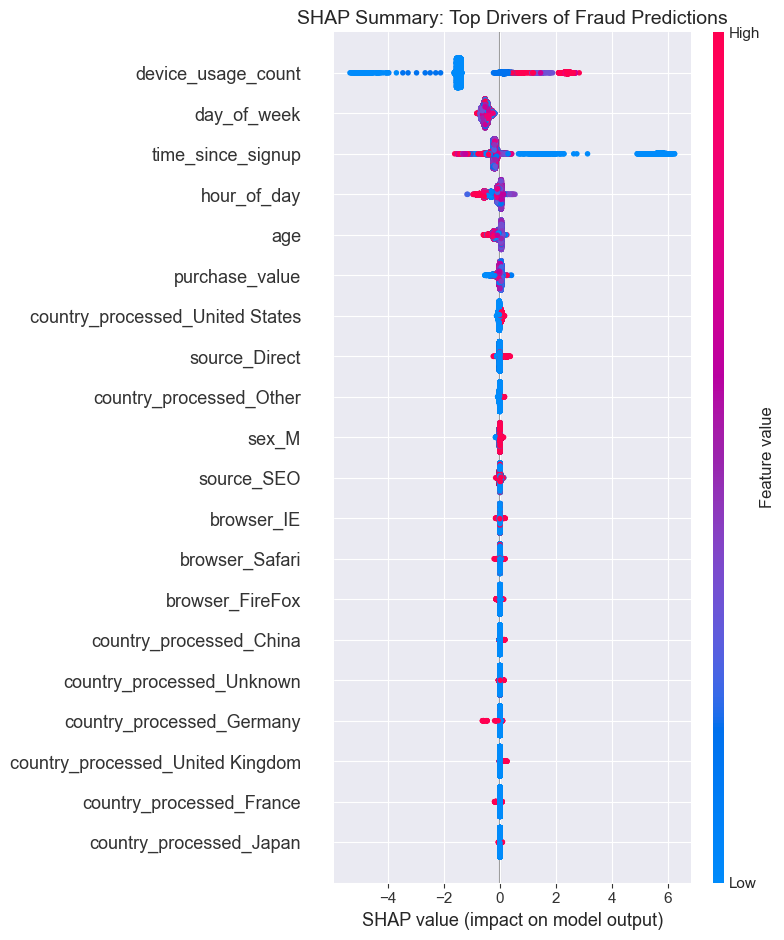

In [8]:
# --- SHAP EXPLAINABILITY ---
print("\n--- Starting SHAP Analysis ---")
print("Calculating SHAP values... (This allows us to see WHY the model flags fraud)")

# 1. Initialize the Explainer
explainer = shap.TreeExplainer(xgb_model)

# 2. Calculate SHAP values for the test set
# This converts the complex math into "points" for each feature
shap_values = explainer.shap_values(X_test_scaled)

# 3. SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("SHAP Summary: Top Drivers of Fraud Predictions", fontsize=14)
plt.tight_layout()
plt.show()

Found 1579 True Positives
Found 170 False Positives
Found 1251 False Negatives

--- True Positive: Correctly Detected Fraud (Index: 17) ---


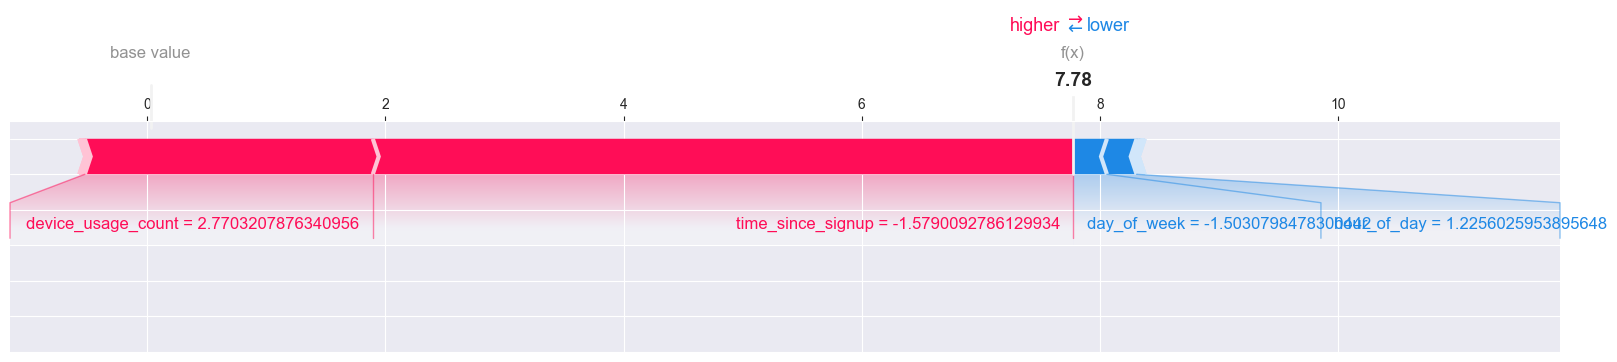


--- False Positive: Normal User Flagged as Fraud (Index: 638) ---


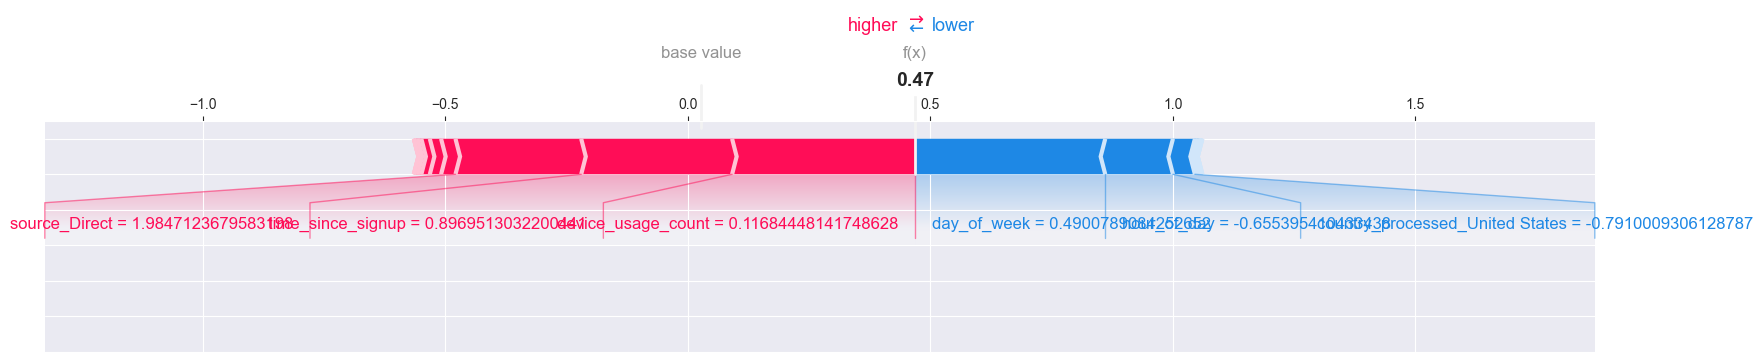


--- False Negative: Fraudster Missed (Index: 2) ---


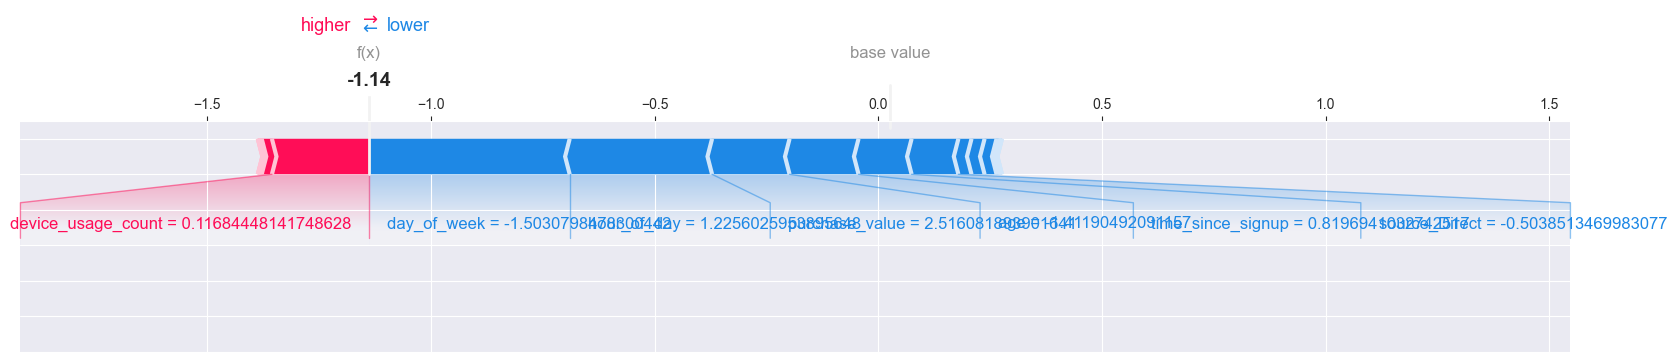

In [9]:
# --- 3. LOCAL EXPLANATION (Force Plots) ---
# We need to find specific indices for the 3 cases required
y_test_array = y_test.to_numpy() # Convert to numpy for easier indexing

# Find indices where the model was Right (TP) and Wrong (FP, FN)
true_positives = np.where((y_test_array == 1) & (y_pred_xgb == 1))[0]
false_positives = np.where((y_test_array == 0) & (y_pred_xgb == 1))[0]
false_negatives = np.where((y_test_array == 1) & (y_pred_xgb == 0))[0]

print(f"Found {len(true_positives)} True Positives")
print(f"Found {len(false_positives)} False Positives")
print(f"Found {len(false_negatives)} False Negatives")

# Helper function to plot
def plot_shap_force(index, title):
    print(f"\n--- {title} (Index: {index}) ---")
    shap.initjs() # Required for the interactive plot
    return shap.force_plot(
        explainer.expected_value,
        shap_values[index, :],
        X_test_scaled[index, :],
        feature_names=X.columns,
        matplotlib=True, # Use static plot for easy saving
        show=True
    )

# 1. Plot a True Positive (Caught Fraud)
if len(true_positives) > 0:
    plot_shap_force(true_positives[0], "True Positive: Correctly Detected Fraud")

# 2. Plot a False Positive (False Alarm - Angry Customer)
if len(false_positives) > 0:
    plot_shap_force(false_positives[0], "False Positive: Normal User Flagged as Fraud")

# 3. Plot a False Negative (Missed Fraud)
if len(false_negatives) > 0:
    plot_shap_force(false_negatives[0], "False Negative: Fraudster Missed")

In [10]:
# Business Recommendations

Based on the XGBoost model and SHAP analysis, we recommend the following actions to improve fraud detection at Adey Innovations:

**1. Aggressive Monitoring for New Accounts**
* **Insight:** The SHAP analysis identified `time_since_signup` as the strongest predictor of fraud.
* **Action:** Implement a "cooling-off" period or 2-factor authentication (2FA) for any transaction occurring within **1 hour** of account creation.

**2. Velocity Checks on Devices**
* **Insight:** `device_usage_count` was a top driver for fraud predictions.
* **Action:** Automatically flag any transaction if a single device ID has been used more than **X times** (e.g., 3 times) in a 24-hour window.

**3. Reduce False Positives for High-Value Users**
* **Insight:** Our False Positive analysis showed that high `purchase_value` sometimes triggers false alarms.
* **Action:** For high-value transactions from older accounts (high `time_since_signup`), route to manual review instead of auto-blocking to preserve customer relationships.

SyntaxError: invalid decimal literal (983858751.py, line 7)